# Analysis Notebook for *"Title"*

This notebook is part of the article *"Title"*. It contains the scripts required to analyze each of the scenarios presented in the study. 

To use this notebook:
- Uncomment the desired scenario in the next cell.
- Execute all cells sequentially to generate the corresponding figures from the article individually.


In [49]:
scenario = '(a) NTP'
# scenario = '(b) TFTP'
# scenario = '(c) Portmap'
# scenario = '(d) LDAP-NetBIOS'
# scenario = '(e) TCP SYN'

In [50]:
import os
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from plotly.offline import init_notebook_mode

init_notebook_mode(connected=True)
dir_path = scenario
traces_path = os.path.join(dir_path, 'traces')
fun_file = os.path.join(dir_path, 'FUN.csv')
var_file = os.path.join(dir_path, 'VAR.csv')

def read_solutions(filepath):
    soluciones = []
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line:
                objetivos = list(map(float, line.split(',')))
                soluciones.append(objetivos)
    return soluciones

soluciones = read_solutions(fun_file)

## 3D Pareto Front Approximation

This script generates an interactive 3D plot of the Pareto front approximation for the selected scenario. The objectives are displayed in a 3D space, where each point represents a solution, and the color intensity reflects the balanced accuracy. 

You can rotate, zoom, and explore the visualization directly within the notebook to better understand the distribution of solutions across the objectives.

In [51]:
def plot_interactive_3D_front():
    
    x_vals = [sol[0] for sol in soluciones]
    y_vals = [sol[1] for sol in soluciones]
    z_vals = [-sol[2] for sol in soluciones]

    fig = go.Figure()

    fig.add_trace(go.Scatter3d(
        x=x_vals,
        y=y_vals,
        z=z_vals,
        mode='markers',
        marker=dict(
            size=5,
            color=z_vals,
            colorscale='Viridis',
            opacity=0.8
        )
    ))

    fig.update_layout(
        scene=dict(
            xaxis_title='n',
            yaxis_title='Features',
            zaxis_title='Balanced accuracy',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
                # up=dict(x=np.cos(np.radians(140)), y=np.sin(np.radians(140)), z=1)
            )
        ),
        height=800,
        margin=dict(l=0, r=0, b=0, t=0)
    )
    
    fig.show()

plot_interactive_3D_front()

## 3D Optimization Process Traces

This script visualizes the optimization process as an interactive 3D plot. Each trace represents the evolution of solutions across the objective space during the optimization process. 

The plot allows you to explore the trajectory of solutions, providing insights into how the algorithm converges toward the unknown Pareto front. You can rotate, zoom, and interact with the visualization to analyze the dynamics of the optimization process in detail.

In [52]:
def get_limits(dir_traces):
    x_vals, y_vals, z_vals = [], [], []
    for filename in sorted(os.listdir(dir_traces), key=lambda f: int(f.split('.')[1])): 
        if filename.startswith('FUN.') and filename.endswith('.csv'):
            filepath = os.path.join(dir_traces, filename)
            _soluciones = read_solutions(filepath)
            x_vals.extend([sol[0] for sol in _soluciones])
            y_vals.extend([sol[1] for sol in _soluciones])
            z_vals.extend([-sol[2] for sol in soluciones])
    return min(x_vals), max(x_vals), min(y_vals), max(y_vals), min(z_vals), max(z_vals)

def plot_dynamic_evolution():
    
    frames = []
    initial_trace = None

    x_min, x_max, y_min, y_max, z_min, z_max = get_limits(traces_path)

    for filename in sorted(os.listdir(traces_path), key=lambda f: int(f.split('.')[1])):
        if filename.startswith('FUN.') and filename.endswith('.csv'):
            evaluaciones = filename.split('.')[1]
            filepath = os.path.join(traces_path, filename)
            
            _soluciones = read_solutions(filepath)
            
            x_vals = [sol[0] for sol in _soluciones]
            y_vals = [sol[1] for sol in _soluciones]
            z_vals = [-sol[2] for sol in _soluciones]

            frames.append(go.Frame(
                data=[go.Scatter3d(
                    x=x_vals,
                    y=y_vals,
                    z=z_vals,
                    mode='markers',
                    marker=dict(
                        size=5,
                        color=z_vals,
                        colorscale='Viridis',
                        opacity=0.8
                    )
                )],
                name=f'{evaluaciones} evaluations'
            ))
            
            if initial_trace is None:
                initial_trace = go.Scatter3d(
                    x=x_vals,
                    y=y_vals,
                    z=z_vals,
                    mode='markers',
                    marker=dict(
                        size=5,
                        color=z_vals,
                        colorscale='Viridis',
                        opacity=0.8
                    ),
                    name=f'{evaluaciones} evaluations'
                )

    x_final = [sol[0] for sol in soluciones]
    y_final = [sol[1] for sol in soluciones]
    z_final = [-sol[2] for sol in soluciones]

    frames.append(go.Frame(
        data=[go.Scatter3d(
            x=x_final,
            y=y_final,
            z=z_final,
            mode='markers',
            marker=dict(
                size=5,
                color=z_final,
                colorscale='Viridis',
                opacity=0.8
            )
        )],
        name='Final population'
    ))

    fig = go.Figure(
        data=[initial_trace],
        frames=frames
    )

    fig.update_layout(
        scene=dict(
            xaxis=dict(title='n', range=[x_min, x_max]),
            yaxis=dict(title='Features', range=[y_min, y_max]),
            zaxis=dict(title='Balanced accuracy', range=[z_min, z_max]),
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        height=800,
        margin=dict(l=0, r=0, b=0, t=0),
        updatemenus=[{
            'buttons': [
                {
                    'args': [None, {'frame': {'duration': 500, 'redraw': True}, 'fromcurrent': True}],
                    'label': 'Play',
                    'method': 'animate'
                },
                {
                    'args': [[None], {'frame': {'duration': 0, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 0}}],
                    'label': 'Pause',
                    'method': 'animate'
                }
            ],
            'direction': 'left',
            'pad': {'r': 10, 't': 87},
            'showactive': False,
            'type': 'buttons',
            'x': 0.1,
            'xanchor': 'right',
            'y': 0,
            'yanchor': 'top'
        }],
        sliders=[{
            'steps': [
                {
                    'args': [[frame.name], {'frame': {'duration': 300, 'redraw': True}, 'mode': 'immediate', 'transition': {'duration': 300}}],
                    'label': frame.name,
                    'method': 'animate'
                } for frame in frames
            ],
            'active': 0,
            'x': 0.1,
            'len': 0.9,
            'xanchor': 'left',
            'yanchor': 'top',
            'pad': {'b': 10, 't': 50}
        }]
    )

    fig.show()

plot_dynamic_evolution()

## Feature Selection Bitmap

This script generates a bitmap visualization of feature selection for each solution in the scenario. Each row represents a solution, and each column corresponds to a specific feature.

Active features are highlighted in black, and each solution has its balance accuracy in the las column. This visualization provides an intuitive way to assess feature utilization patterns and their relationship with solution quality.

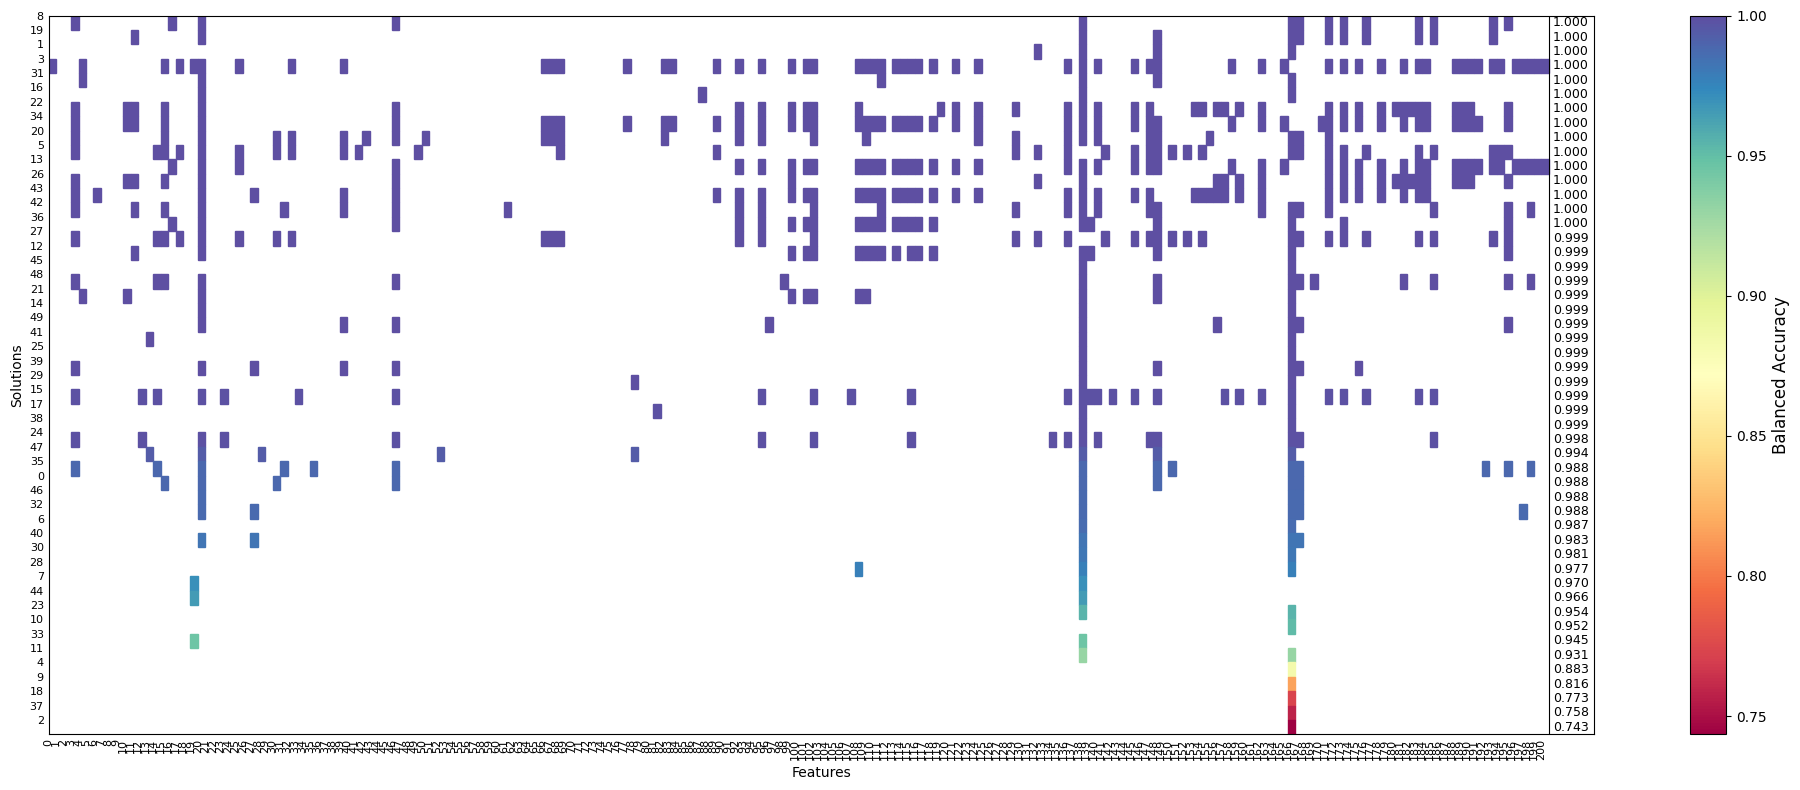

In [53]:
def extract_bitstrings(var_file):
    bitstrings = []
    with open(var_file, 'r') as var_f:
        for line in var_f:
            line = line.strip()
            if line.startswith("Variables:"):
                bitstring = line.split("Variables:")[1].split()[0]
                bitstrings.append(bitstring)
    return bitstrings

def bitmap():
    bitstrings = extract_bitstrings(var_file)
    accuracies = [-accuracy[2] for accuracy in read_solutions(fun_file)]

    # Crear matriz de bits y ordenar según accuracies
    bit_matrix = np.array([[int(bit) for bit in bitstring] for bitstring in bitstrings])
    sorted_indices = np.argsort(accuracies)[::-1]
    bit_matrix = bit_matrix[sorted_indices]
    accuracies_sorted = np.array(accuracies)[sorted_indices]

    # Normalizar accuracies para usar en el colormap
    norm = plt.Normalize(vmin=min(accuracies_sorted), vmax=max(accuracies_sorted))
    cmap = plt.get_cmap('Spectral')

    # Crear la figura
    fig, ax = plt.subplots(figsize=(20, 8))

    for i, row in enumerate(bit_matrix):
        for j, bit in enumerate(row):
            if bit == 1:
                color = cmap(norm(accuracies_sorted[i]))
                ax.add_patch(plt.Rectangle((j, i), 1, 1, color=color, edgecolor=None))

    # Mostrar valores de balanced accuracy al final de cada fila
    for i, accuracy in enumerate(accuracies_sorted):
        ax.text(bit_matrix.shape[1] + 0.5, i + 0.5, f'{accuracy:.3f}', va='center', ha='left', fontsize=9)

    # Agregar colorbar para el balanced accuracy
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical')
    cbar.set_label('Balanced Accuracy', fontsize=12)

    # Configurar ejes
    ax.axvline(x=bit_matrix.shape[1], color='black', linewidth=0.8)
    ax.set_xlabel('Features')
    ax.set_ylabel('Solutions')
    ax.set_xticks(range(bit_matrix.shape[1]))
    ax.set_xticklabels(range(0, bit_matrix.shape[1]), fontsize=8, rotation=90)
    ax.set_yticks(range(bit_matrix.shape[0]))
    ax.set_yticklabels(sorted_indices, fontsize=8)
    ax.tick_params(axis='both', which='both', length=0)

    ax.set_xlim(-0, bit_matrix.shape[1] + 6)
    ax.set_ylim(bit_matrix.shape[0], 0)

    plt.tight_layout()
    plt.show()

bitmap()

## Heatmap of $\tau$ Proportions

This script creates a heatmap that visualizes the proportion of $\tau_3$, $\tau_4$, and $\tau_5$ values across all solutions for a given scenario. Each column corresponds to a solution, and the rows represent the proportions of each $\tau$ component.

The heatmap provides a clear representation of the distribution of $\tau$ proportions, facilitating the analysis of how these components contribute to the solutions in the optimization process.

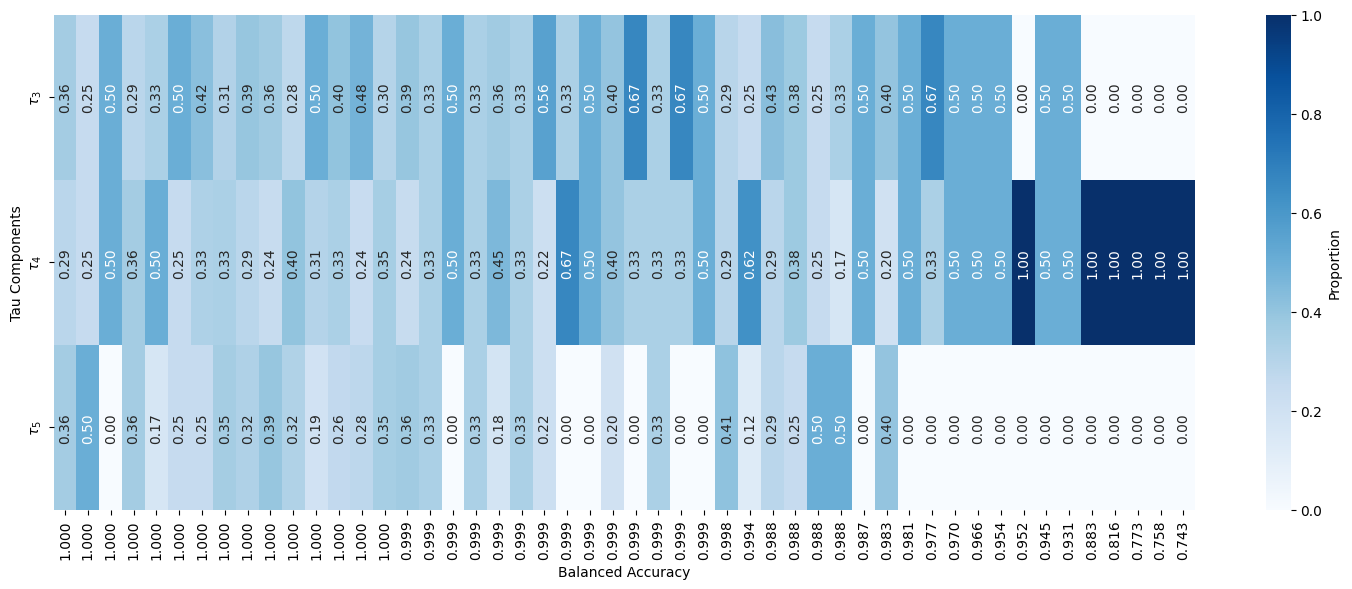

In [54]:
def tau_heatmap():
    accuracies = []
    with open(fun_file, 'r') as fun_f:
        for line in fun_f:
            line = line.strip()
            if line:
                objectives = list(map(float, line.split(',')))
                accuracies.append(-objectives[2])

    tau3_counts, tau4_counts, tau5_counts = [], [], []

    with open(var_file, 'r') as var_f:
        for line in var_f:
            line = line.strip()
            if line.startswith("Variables:"):
                bitstring = line.split("Variables:")[1].strip().split()[0]
                tau3_counts.append(sum(1 for i, bit in enumerate(bitstring) if bit == '1' and i % 3 == 0))
                tau4_counts.append(sum(1 for i, bit in enumerate(bitstring) if bit == '1' and i % 3 == 1))
                tau5_counts.append(sum(1 for i, bit in enumerate(bitstring) if bit == '1' and i % 3 == 2))

    if len(accuracies) != len(tau3_counts):
        print("Error: La cantidad de soluciones en FUN.csv y VAR.csv no coincide.")
        return

    data = pd.DataFrame({
        'accuracy': accuracies,
        'tau3': tau3_counts,
        'tau4': tau4_counts,
        'tau5': tau5_counts
    }).sort_values(by='accuracy', ascending=False)

    tau_data = data[['tau3', 'tau4', 'tau5']].div(data[['tau3', 'tau4', 'tau5']].sum(axis=1), axis=0)
    heatmap_data = tau_data.T.values
    x_labels = [f'{acc:.3f}' for acc in data['accuracy']]
    y_labels = [r'$\tau_3$', r'$\tau_4$', r'$\tau_5$']

    num_solutions = len(accuracies)
    width_per_solution = 0.3
    fig_width = max(5, min(20, num_solutions * width_per_solution))

    plt.figure(figsize=(fig_width, 6))
    sns.heatmap(
        heatmap_data,
        annot=True,
        fmt='.2f',
        cmap='Blues',
        cbar=True,
        xticklabels=x_labels,
        yticklabels=y_labels,
        annot_kws={'rotation': 90},
        cbar_kws={'label': 'Proportion'}
    )
    plt.xlabel('Balanced Accuracy')
    plt.ylabel('Tau Components')
    plt.tight_layout()

    plt.show()

tau_heatmap()
